In [1]:
from data import load_feature_and_outcome, load_reference_genes
from utils import *

from matplotlib import pyplot as plt
import numpy as np
from copy import deepcopy
import pandas as pd

In [2]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.svm import LinearSVC

In [7]:
import pickle

In [4]:
gene_names, features, labels, feature_map_tables = load_feature_and_outcome(
    feature_path='./data/sc3_Phase1_CN_GE_FeatureMatrix.tsv',
    phenotype_path='./data/sc3_Phase1_CN_GE_Phenotype.tsv',
    outcome_path='./data/sc3_Phase1_CN_GE_Outcome.tsv',
    shuffle=True
)

In [138]:
feature_map_tables

{'SEX': Index([' ', 'FEMALE', 'MALE'], dtype='object'),
 'RACE': Index(['ASIAN', 'BLACK', 'WHITE'], dtype='object'),
 'WHO_GRADING': Index(['II', 'III', 'IV'], dtype='object'),
 'CANCER_TYPE': Index(['ASTROCYTOMA', 'GBM', 'MIXED', 'OLIGODENDROGLIOMA', 'UNCLASSIFIED',
        'UNKNOWN'],
       dtype='object')}

Extract the features obtained from sc1 and sc2

In [5]:
def load_model(path):
    with open(path, 'rb') as f:
        classifier, feature_names, map_table = pickle.load(f)
    return classifier, feature_names, map_table

In [8]:
model_info_sc1 = load_model('./final_classifier_GE.pkl')
model_info_sc2 = load_model('./final_classifier_CN.pkl')

In [21]:
selected_feature_names = set(list(model_info_sc1[1])+list(model_info_sc2[1]))

In [22]:
gene_names

array(['SEX', 'RACE', 'WHO_GRADING', ..., '22q13.31', '22q13.32',
       '22q13.33'], dtype='<U22')

In [23]:
feature_mask = inset(gene_names, selected_feature_names)

In [29]:
feature_mask.sum(), len(selected_feature_names)

(63, 63)

# fit feature and classifier params in epoches

In [30]:
selected_feature_final = features[:,feature_mask]

In [31]:
selected_feature_names = gene_names[feature_mask]

In [32]:
selected_feature_names

array(['SEX', 'RACE', 'AATF', 'ABRAXAS1', 'AP1S1', 'C14orf93', 'C2orf68',
       'CUL9', 'DUSP3', 'HAUS4', 'HIST1H2BB', 'LBHD1', 'LOC401261',
       'NRN1', 'PCMTD1', 'PUM1', 'PURA', 'RANGRF', 'RASSF4', 'RAVER2',
       'RPL4', 'SMURF2', 'SPEN', 'SRD5A1', 'WDR11', 'ZNF32', '1p36.31',
       '1p34.1', '1p32.2', '1p31.1', '1p21.2', '2p25.3', '3p25.1',
       '3p12.2', '4p16.2', '5p14.2', '5p14.1', '5q11.1', '5q11.2',
       '5q21.3', '5q31.2', '6q22.33', '7q31.1', '8q21.3', '8q22.3',
       '8q23.1', '8q24.12', '8q24.13', '8q24.21', '8q24.3', '9p24.1',
       '9p21.3', '9p21.1', '9p12', '9q31.2', '9q33.2', '9q34.3',
       '10q11.23', '11p15.4', '12q24.11', '13q12.11', '21q11.1',
       '21q11.2'], dtype='<U22')

find a params

In [54]:
params_candidate = {
    'n_estimators':[100,200],
    'max_depth':[2,4,8],
    'min_child_weight':[1,2],
    'n_jobs':[8],
    'colsample_bynode':[0.5,1],
    'gamma':[1.2,0]
}

In [55]:
search_result = grid_search(selected_feature_final, labels, test_xgb, params_candidate, replicates=100)

Running grid search on 48 set of params...
Eval 48.00 of 48 params...      

In [56]:
params_list, scores_list, baseline_list = search_result

averaged_score = (np.array(scores_list) - np.array(baseline_list)).mean(axis=1)
params_list_np = np.array(params_list)

sort_index = np.argsort(-averaged_score[:,1])
sorted_params_list = params_list_np[sort_index]

In [61]:
averaged_score[sort_index]

array([[0.2405303 , 0.04882353],
       [0.23977273, 0.04852941],
       [0.2405303 , 0.04794118],
       [0.2405303 , 0.04735294],
       [0.23113636, 0.04735294],
       [0.23325758, 0.04735294],
       [0.23969697, 0.04735294],
       [0.2325    , 0.04705882],
       [0.23924242, 0.04647059],
       [0.2405303 , 0.04617647],
       [0.23227273, 0.04617647],
       [0.23931818, 0.04588235],
       [0.2405303 , 0.04588235],
       [0.2405303 , 0.04558824],
       [0.2405303 , 0.04470588],
       [0.2405303 , 0.04441176],
       [0.24045455, 0.04441176],
       [0.2405303 , 0.04441176],
       [0.23772727, 0.04382353],
       [0.2405303 , 0.04352941],
       [0.23689394, 0.04352941],
       [0.2405303 , 0.04323529],
       [0.23121212, 0.04294118],
       [0.23113636, 0.04294118],
       [0.2405303 , 0.04205882],
       [0.23984848, 0.04176471],
       [0.23765152, 0.04176471],
       [0.24045455, 0.04117647],
       [0.23674242, 0.04117647],
       [0.23969697, 0.04088235],
       [0.

In [71]:
sorted_params_list

array([{'gamma': 0, 'colsample_bynode': 0.5, 'n_jobs': 8, 'min_child_weight': 1, 'max_depth': 4, 'n_estimators': 200},
       {'gamma': 1.2, 'colsample_bynode': 0.5, 'n_jobs': 8, 'min_child_weight': 1, 'max_depth': 8, 'n_estimators': 200},
       {'gamma': 0, 'colsample_bynode': 0.5, 'n_jobs': 8, 'min_child_weight': 2, 'max_depth': 2, 'n_estimators': 200},
       {'gamma': 0, 'colsample_bynode': 0.5, 'n_jobs': 8, 'min_child_weight': 2, 'max_depth': 8, 'n_estimators': 200},
       {'gamma': 1.2, 'colsample_bynode': 0.5, 'n_jobs': 8, 'min_child_weight': 2, 'max_depth': 2, 'n_estimators': 100},
       {'gamma': 1.2, 'colsample_bynode': 0.5, 'n_jobs': 8, 'min_child_weight': 1, 'max_depth': 2, 'n_estimators': 200},
       {'gamma': 1.2, 'colsample_bynode': 0.5, 'n_jobs': 8, 'min_child_weight': 1, 'max_depth': 8, 'n_estimators': 100},
       {'gamma': 1.2, 'colsample_bynode': 0.5, 'n_jobs': 8, 'min_child_weight': 2, 'max_depth': 2, 'n_estimators': 200},
       {'gamma': 1.2, 'colsample_bynod

In [72]:
params = sorted_params_list[0]

In [73]:
params

{'gamma': 0,
 'colsample_bynode': 0.5,
 'n_jobs': 8,
 'min_child_weight': 1,
 'max_depth': 4,
 'n_estimators': 200}

In [74]:
dataset = data_split(selected_feature_final, labels)
baseline = (dataset[0][1].mean(), dataset[1][1].mean())
performance = test_xgb(dataset, **params)
print ((performance),'\n',(baseline))

(1.0, 0.8823529411764706) 
 (0.7348484848484849, 0.8529411764705882)


In [75]:
results_single = []

In [76]:
for i in range(100):
    _dataset = data_split(selected_feature_final, labels)
    _baseline = np.array((_dataset[0][1].mean(), _dataset[1][1].mean()))
    results_single.append(np.array(test_clf(_dataset, XGBClassifier, **params)) - _baseline)
    
    print ('perform gain:  %.4f %.4f, %.4f %.4f' % (tuple(results_single[-1]) + tuple(_baseline)))

perform gain:  0.2197 -0.0294, 0.7803 0.6765
perform gain:  0.2348 0.0588, 0.7652 0.7353
perform gain:  0.2348 0.0294, 0.7652 0.7353
perform gain:  0.2576 0.0000, 0.7424 0.8235
perform gain:  0.2197 0.0588, 0.7803 0.6765
perform gain:  0.2424 -0.0588, 0.7576 0.7647
perform gain:  0.2348 0.1471, 0.7652 0.7353
perform gain:  0.2348 0.0294, 0.7652 0.7353
perform gain:  0.2348 0.1471, 0.7652 0.7353
perform gain:  0.2121 0.1471, 0.7879 0.6471
perform gain:  0.2348 0.0588, 0.7652 0.7353
perform gain:  0.2424 0.0294, 0.7576 0.7647
perform gain:  0.2803 -0.0882, 0.7197 0.9118
perform gain:  0.2121 0.0882, 0.7879 0.6471
perform gain:  0.2273 0.1176, 0.7727 0.7059
perform gain:  0.2652 0.0000, 0.7348 0.8529
perform gain:  0.2273 0.0588, 0.7727 0.7059
perform gain:  0.2727 -0.0294, 0.7273 0.8824
perform gain:  0.2273 0.0882, 0.7727 0.7059
perform gain:  0.2348 0.0588, 0.7652 0.7353
perform gain:  0.2273 0.1471, 0.7727 0.7059
perform gain:  0.2576 0.0294, 0.7424 0.8235
perform gain:  0.2273 0.0294

In [77]:
results_single = np.array(results_single)

In [78]:
results_single.mean(axis=0)

array([0.2394697 , 0.03735294])

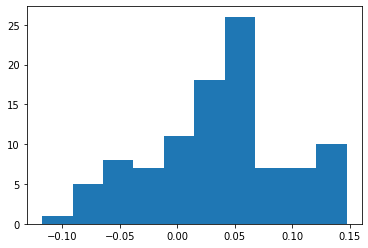

In [79]:
_=plt.hist(results_single[:,1], bins=10)

this params seems to be ok, filter the features.

In [80]:
from xgboost.sklearn import XGBClassifier

In [81]:
train_dataset, valid_dataset = data_split(selected_feature_final, labels, fraction=0.8)

feature_importance = np.zeros(selected_feature_final.shape[1], dtype='float')
for i in range(200):
    print('\r%2d/%2d  ' % (i+1,200), end='')
    _train_dataset, _ = data_split(*train_dataset, fraction=0.8)
    clf = XGBClassifier(**params)
    clf.fit(*_train_dataset)
    feature_importance += clf.feature_importances_
    
feature_importance /= 200

200/200  

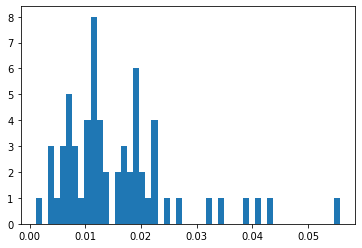

In [82]:
_=plt.hist(feature_importance, bins=50)

it seems 0.015 would be the 1st level, 0.02 be the second level.

In [83]:
# 1st level features
(feature_importance > 0.015).sum()

28

In [87]:
selected_feature_names[feature_importance > 0.015]

array(['SEX', 'RACE', 'AATF', 'ABRAXAS1', 'AP1S1', 'C14orf93', 'C2orf68',
       'DUSP3', 'HAUS4', 'NRN1', 'PCMTD1', 'PURA', 'RASSF4', 'RPL4',
       'SMURF2', 'SPEN', 'SRD5A1', 'WDR11', 'ZNF32', '1p36.31', '2p25.3',
       '4p16.2', '5p14.2', '5p14.1', '9p24.1', '9p21.3', '9q31.2',
       '21q11.2'], dtype='<U22')

In [88]:
# level 0 features
(feature_importance > 0.02).sum()

15

In [89]:
selected_feature_names[feature_importance > 0.02]

array(['RACE', 'AATF', 'DUSP3', 'NRN1', 'PCMTD1', 'PURA', 'RPL4', 'SPEN',
       'SRD5A1', 'WDR11', '5p14.2', '5p14.1', '9p24.1', '9p21.3',
       '9q31.2'], dtype='<U22')

so test these stages

level 0 newly added

In [102]:
feature_0_stage = selected_feature_final[:,feature_importance > 0.02]
scores_0 = []
baselines_0 = []
for i in range(100):
    print('\r%2d/%2d  ' % (i+1,100), end='')
    dataset = data_split(feature_0_stage, labels, fraction=0.7)
    baseline = (dataset[0][1].mean(), dataset[1][1].mean())
    perform = test_xgb(dataset, **params)
    
    scores_0.append(perform)
    baselines_0.append(baseline)

100/100  

In [103]:
score_0 = np.asarray(scores_0).reshape(-1,2)
baseline_0 = np.array(baselines_0)

In [104]:
(score_0 - baseline_0).mean(axis=0)

array([0.24301724, 0.059     ])

In [93]:
feature_1st_stage = selected_feature_final[:,feature_importance > 0.015]
scores_1st = []
baselines_1st = []
for i in range(100):
    print('\r%2d/%2d  ' % (i+1,100), end='')
    dataset = data_split(feature_1st_stage, labels, fraction=0.7)
    baseline = (dataset[0][1].mean(), dataset[1][1].mean())
    perform = test_xgb(dataset, **params)
    
    scores_1st.append(perform)
    baselines_1st.append(baseline)

100/100  

In [94]:
score_1st = np.asarray(scores_1st).reshape(-1,2)
baseline_1st = np.array(baselines_1st)

In [95]:
(score_1st - baseline_1st).mean(axis=0)

array([0.24051724, 0.052     ])

In [96]:
feature_2nd_stage = selected_feature_final[:,feature_importance > 0.01]
scores_2nd = []
baselines_2nd = []
for i in range(100):
    print('\r%2d/%2d  ' % (i+1,100), end='')
    dataset = data_split(feature_2nd_stage, labels, fraction=0.7)
    baseline = (dataset[0][1].mean(), dataset[1][1].mean())
    perform = test_xgb(dataset, **params)
    
    scores_2nd.append(perform)
    baselines_2nd.append(baseline)

100/100  

In [97]:
score_2nd = np.asarray(scores_2nd).reshape(-1,2)
baseline_2nd = np.array(baselines_2nd)

In [98]:
(score_2nd - baseline_2nd).mean(axis=0)

array([0.24043103, 0.0386    ])

there's no doubt to select 1st level

let's check the final feature we selected:

In [105]:
selected_feature_names[feature_importance > 0.02]

array(['RACE', 'AATF', 'DUSP3', 'NRN1', 'PCMTD1', 'PURA', 'RPL4', 'SPEN',
       'SRD5A1', 'WDR11', '5p14.2', '5p14.1', '9p24.1', '9p21.3',
       '9q31.2'], dtype='<U22')

In [106]:
params

{'gamma': 0,
 'colsample_bynode': 0.5,
 'n_jobs': 8,
 'min_child_weight': 1,
 'max_depth': 4,
 'n_estimators': 200}

In [107]:
results_single = []

In [108]:
for i in range(100):
    _dataset = data_split(feature_0_stage, labels)
    _baseline = np.array((_dataset[0][1].mean(), _dataset[1][1].mean()))
    results_single.append(np.array(test_clf(_dataset, XGBClassifier, **params)) - _baseline)
    
    print ('perform gain:  %.4f %.4f, %.4f %.4f' % (tuple(results_single[-1]) + tuple(_baseline)))

perform gain:  0.2348 0.1471, 0.7652 0.7353
perform gain:  0.2424 0.0294, 0.7576 0.7647
perform gain:  0.2273 0.0294, 0.7727 0.7059
perform gain:  0.2273 0.0882, 0.7727 0.7059
perform gain:  0.2348 0.0882, 0.7652 0.7353
perform gain:  0.2652 0.0000, 0.7348 0.8529
perform gain:  0.2424 0.0294, 0.7576 0.7647
perform gain:  0.2197 0.1471, 0.7803 0.6765
perform gain:  0.2652 0.0588, 0.7348 0.8529
perform gain:  0.2121 0.1471, 0.7879 0.6471
perform gain:  0.2424 0.0588, 0.7576 0.7647
perform gain:  0.2500 0.0882, 0.7500 0.7941
perform gain:  0.2424 0.1176, 0.7576 0.7647
perform gain:  0.2348 0.0882, 0.7652 0.7353
perform gain:  0.2273 0.0588, 0.7727 0.7059
perform gain:  0.2273 0.1176, 0.7727 0.7059
perform gain:  0.2424 0.0000, 0.7576 0.7647
perform gain:  0.2500 0.0294, 0.7500 0.7941
perform gain:  0.2652 0.0882, 0.7348 0.8529
perform gain:  0.2424 0.0294, 0.7576 0.7647
perform gain:  0.2576 0.0588, 0.7424 0.8235
perform gain:  0.2424 0.0588, 0.7576 0.7647
perform gain:  0.2424 0.0882, 0.

In [109]:
results_single = np.array(results_single)

In [110]:
results_single.mean(axis=0)

array([0.24083333, 0.06911765])

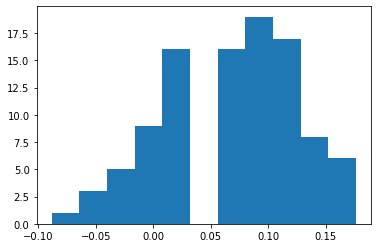

In [111]:
_=plt.hist(results_single[:,1], bins=11)

In [112]:
(results_single[:,1]>0).mean() * 100

82.0

In [113]:
(results_single[:,1]==0).mean() * 100

9.0

In [114]:
(results_single[:,1]<0).mean() * 100

9.0

# build final classifiers

In [115]:
dataset = data_split(feature_1st_stage, labels)

In [116]:
train_dataset, valid_dataset = dataset
train_features, train_labels = train_dataset
valid_features, valid_labels = valid_dataset

clf = XGBClassifier(**params)
clf.fit(train_features, train_labels)

predicted_train = clf.predict(train_features)
train_acc = (predicted_train == train_labels).mean()

predicted_valid = clf.predict(valid_features)
valid_acc = (predicted_valid == valid_labels).mean()

print (train_labels.mean(), valid_labels.mean())
print (train_acc, valid_acc)

0.7575757575757576 0.7647058823529411
1.0 0.7647058823529411


In [130]:
(features_8, labels_8), (features_2, labels_2) = data_split(selected_feature_final, labels, fraction=0.8)

In [131]:
clf = XGBClassifier(**params)
clf.fit(features_8[:,feature_importance > 0.02], labels_8)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=0.5, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=8,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [132]:
test_feature = features_2[:,feature_importance > 0.02]

In [133]:
predicted_test = clf.predict(test_feature)
test_acc = (predicted_test == labels_2).mean()

In [134]:
test_acc

0.9117647058823529

In [135]:
labels_2.mean()

0.7941176470588235

In [136]:
import pickle

In [137]:
with open('final_classifier_GE_CN.pkl', 'wb') as f:
    pickle.dump([clf, selected_feature_names[feature_importance > 0.01], feature_map_tables], f)

# model usage:
    load the model file with pickle, get a tuple of (classifier, feature_names, feature_map_table)
    find feature mentioned in feature_names, if it is in the feature_map_tables, map it with its index, use classifier to get the result.

In [532]:
with open('final_classifier_GE_CN.pkl', 'rb') as f:
    classifier, feature_names, map_table = pickle.load(f)

In [139]:
from sklearn.metrics import confusion_matrix, roc_auc_score

confusion_matrixs = []
roc_aucs = []

In [158]:
(1-labels.mean())/labels.mean()

0.31746031746031744

In [162]:
params

{'gamma': 0,
 'colsample_bynode': 0.5,
 'n_jobs': 8,
 'min_child_weight': 1,
 'max_depth': 4,
 'n_estimators': 200}

In [159]:
for i in range(100):
    print('\r%2d/%2d  ' % (i+1,100), end='')
    train_dataset, valid_dataset = data_split(feature_1st_stage, labels)
    train_features, train_labels = train_dataset
    valid_features, valid_labels = valid_dataset
    
    clf = XGBClassifier(scale_pos_weight=0.3175,**params)
    clf.fit(train_features, train_labels)
    
    predicted_proba_valid = clf.predict_proba(valid_features)
    predicted_valid = clf.predict(valid_features)
    
    confusion_matrixs.append(confusion_matrix(y_true=valid_labels, y_pred=predicted_valid))
    roc_aucs.append(roc_auc_score(y_true=valid_labels, y_score=predicted_proba_valid[:,1]))

100/100  

In [160]:
averaged_confusion_matrix = np.array(confusion_matrixs).mean(axis=0)

tn, fp, fn, tp = averaged_confusion_matrix.ravel()

# specificity
print ('specificity: %.4f' % (tn/(tn+fp)))

# sensitivity
print ('sensitivity: %.4f' % (tp/(tp+fn)))

specificity: 0.5623
sensitivity: 0.9013


In [161]:
np.array(roc_aucs).mean()

0.8370409659374434

In [163]:
for i in range(100):
    print('\r%2d/%2d  ' % (i+1,100), end='')
    train_dataset, valid_dataset = data_split(feature_1st_stage, labels)
    train_features, train_labels = train_dataset
    valid_features, valid_labels = valid_dataset
    
    clf = XGBClassifier(**params)
    clf.fit(train_features, train_labels)
    
    predicted_proba_valid = clf.predict_proba(valid_features)
    predicted_valid = clf.predict(valid_features)
    
    confusion_matrixs.append(confusion_matrix(y_true=valid_labels, y_pred=predicted_valid))
    roc_aucs.append(roc_auc_score(y_true=valid_labels, y_score=predicted_proba_valid[:,1]))

100/100  

In [164]:
averaged_confusion_matrix = np.array(confusion_matrixs).mean(axis=0)

tn, fp, fn, tp = averaged_confusion_matrix.ravel()

# specificity
print ('specificity: %.4f' % (tn/(tn+fp)))

# sensitivity
print ('sensitivity: %.4f' % (tp/(tp+fn)))

specificity: 0.5469
sensitivity: 0.9051


In [165]:
np.array(roc_aucs).mean()

0.8365773610261766